# Running an inference example with the image processing server

in this notebook, we demonstrate how to interact with the image processing server to run an inference on images.  
In this specific example, we'll configure the server for micronuclei classification and detect micronuclei in an example image.

In [1]:
import json
import numpy as np
import requests
import base64
from skimage.io import imread
import matplotlib.pyplot as plt
from magic_tools.server.API_utils import decode_img

Double-check that the repository folder is here correct 

In [2]:
import os
repo_folder = os.path.dirname(os.path.abspath(""))
print(repo_folder)

/home/cosenza/PAPER_REPOS/magic_tools


## Launching the server

Open a terminal and navigate to the magic_tools package folder.  
`cd /path/to/magic_tools/`  
Then launch the server with the following command:  
`uvicorn magic_tools.server.main:app --reload --port 10123`  
Adjust the url address and port to match the ones of the server:

In [3]:
server_url = 'http://127.0.0.1' # your machine
port = '10123' # port

Let's check if the server url and port are correct and the server is running

In [4]:
check = requests.get(server_url + ':' + port + '/docs')
if check.status_code == 200:
    print('server online')
else:
    print('error, status code: {}'.format(check.status_code))

server online


## Setting server configuration

We now configure the server to execute a specific task, to do this we need to send a configuration file to the server.  

In [5]:
config_path = os.path.join(repo_folder, 'resources', 'configurations', 'config_micronuclei_template.json')

In [6]:
with open(config_path, 'r') as f:
    config = json.load(f)

We set here absolute paths to classifiers' locations  
and update the configuration file

In [7]:
config['workers']['collection_dict']['clf_pix'] = os.path.join(
    repo_folder, 'resources', 'classifiers', '2022-08-23_pixel_MCF-10A_H2B-Dendra2.pkl')
config['workers']['collection_dict']['clf_mni'] = os.path.join(
    repo_folder, 'resources', 'classifiers', '2022-08-30_micronuclei_MCF-10A_H2B-Dendra2.pkl')

In [8]:
config_path = os.path.join(repo_folder, 'resources', 'configurations', 'config_micronuclei_template.updated.json')
with open(config_path, 'w') as f:
    json.dump(config, f)

Finally, we send the configuration to the server

In [9]:
res = requests.post(server_url + ':' + port + '/set_config', json={'filepath': config_path})

In [10]:
if res.status_code == 200:
    print('configuration set successfully')
else:
    print('error, status code: {}'.format(check.status_code))

configuration set successfully


## Running the inference

We load here an image that we want to send for classification

In [11]:
img_path = os.path.join(repo_folder, 'resources', 'training_sets', 'pixel_classification', 'mip', 'img4.tif')

In [12]:
img = imread(img_path)

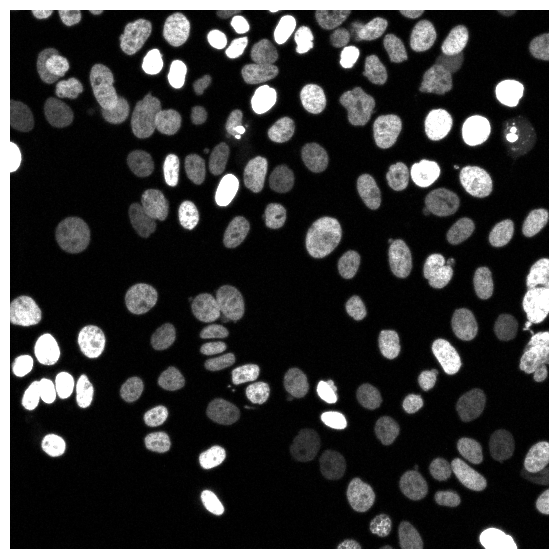

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(img, cmap='gray', vmax=110)
ax.set_axis_off()

the image is sent to a specific endpoint, associated with the image analysis task we want to perform  
in this case it is `mni_classify`

In [14]:
pipeline_url = server_url + ':' + port + '/' + 'mni_classify'

the image is encoded in base64 and packaged with some metadata in a json

In [15]:
byte_content = base64.b64encode(img)  # to bytes
string_content = byte_content.decode('utf-8')  # to string

# request
json_req = {'filename': 'test_image',
            'img': string_content,
            'width': img.shape[1],
            'height': img.shape[0],
            'dtype': img.dtype.str}

Here we send the image to the server  
The first inference is slower, as all threads for parallel processing are created.  
The following inferences will reuse the existing threads and execute faster.  
You can also follow the server response on the terminal.

In [17]:
res = requests.post(pipeline_url, json=json_req)

## Visualize the output

The image is also send back encoded in base64, so it need decoding

In [18]:
output = res.json()
img_output = decode_img(output['img'], output['width'], output['height'], output['dtype'])

Nuclei carrying micronuclei are visualized here with red mask overlay 

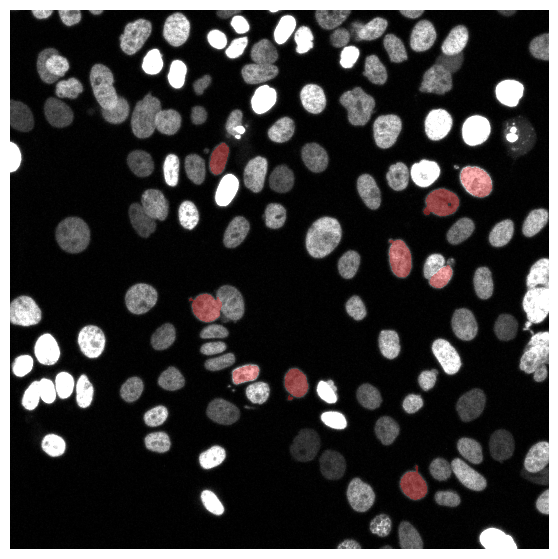

In [19]:
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(img, cmap='gray', vmax=110)
ax.imshow(np.ma.array(img_output, mask=img_output==0), cmap='prism', alpha=.3)
ax.set_axis_off()

We visualize here the detected nuclei.

In [20]:
from scipy.ndimage import center_of_mass, label
lbls, n_lbls = label(img_output)
coords = center_of_mass(img_output, labels=lbls, index=range(1,n_lbls+1))
coords = np.array(coords).astype(int)

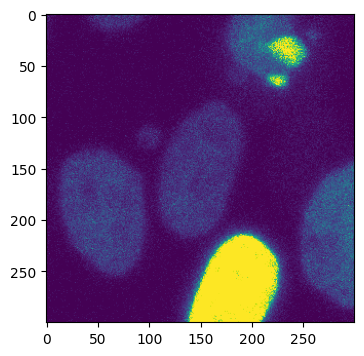

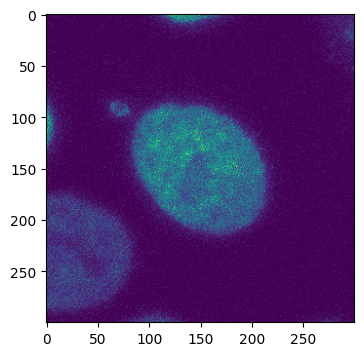

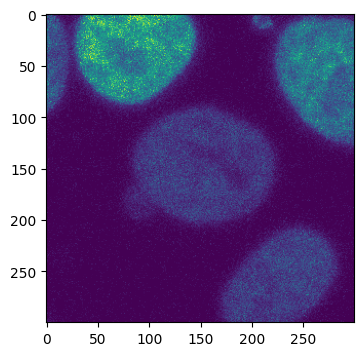

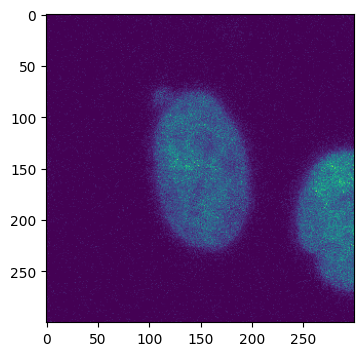

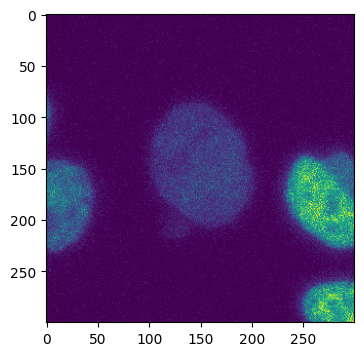

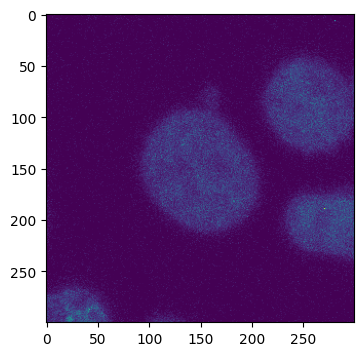

In [21]:
for y,x in coords:
    #s = slice(
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(img[y-150:y+150, x-150:x+150])